In [ ]:
# 개인저장소에 있는 파일(inputdata)을 불러오기
from google.colab import files
myfile = files.upload()

Saving 816block.csv to 816block.csv


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1464 entries, 0 to 1463
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Time       1464 non-null   object
 1   Discharge  1464 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 23.0+ KB


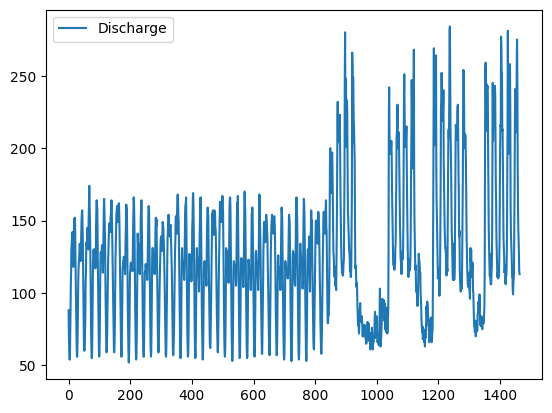

In [ ]:
#모듈설치
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split



# input data 데이터프레임(표 형식)으로 변수에 저장해주기
X_data = pd.read_csv("816block.csv") ####################################### 파일명변경


X_data.info()

X_data.plot()
# NaN 값이 있는 행 삭제
X_data.dropna(inplace=True)

(1464, 1)


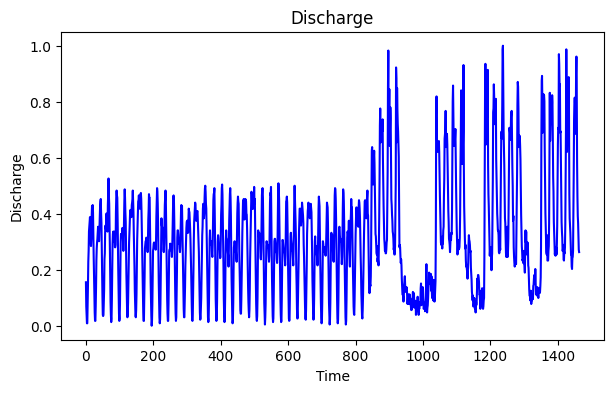

In [ ]:
# 데이터가 3.3~3.6 범위에 모여있으니 min-max scaler를 사용해 0과 1사이의 값으로 만들어줌
from sklearn.preprocessing import MinMaxScaler

#스케일러 생성
scaler = MinMaxScaler()

# Water_Pressure 열에 Min-Max 스케일링 적용
scale_coles = ['Discharge'] ####################################### column명 변경
X_scaled = scaler.fit_transform(X_data[scale_coles])

# 스케일링된 데이터 셋을 데이터프레임(표 형식)으로 다시 변수에 저장
X_scaled = pd.DataFrame(X_scaled, columns = scale_coles)

# 저장이 잘 됐는지 변수 보기
print(X_scaled.shape)

plt.figure(figsize=(7,4))
plt.title("Discharge") #그래프제목
plt.ylabel('Discharge') #y축 범례
plt.xlabel('Time') #x축 범례
plt.plot(X_scaled[scale_coles], label ='Discharge', color='b') # 데이터의 waterpressure 열로 파란색(color = 'b') 그래프 만들기
plt.show()

In [ ]:
# 시퀀스 길이 (몇일을 바탕으로 예측할건지) 생성
window_size = 5

# 시간 컬럼이 아닌 값이 적혀져있는 컬럼 따로 호출, 시계열데이터 특성상 feature label 둘이 똑같은 컬럼 사용
X = pd.DataFrame(X_scaled, columns = scale_coles)
Y = pd.DataFrame(X_scaled, columns = scale_coles)

# features 는 시계열 데이터에서의 X 입력데이터 labels 는  시계열 데이터에서 Y 목표데이터. window_size - sequance 길이.

# 시퀀셜 데이터로 만드는 함수 (빈리스트에 데이터 추가하는 형태)

def make_sequence_dataset(X, Y, window_size):
    feature_list = []
    label_list = []
    for i in range(len(X) - window_size):
        x = X.iloc[i:(i + window_size)]
        y = Y.iloc[i + window_size]
        feature_list.append(x)
        label_list.append(y)
    return np.array(feature_list), np.array(label_list)

# 함수 호출
feature, label = make_sequence_dataset(X, Y, window_size)

# 스케일러복구해서 시퀀스데이터 확인
feature_original = np.array([scaler.inverse_transform(f) for f in feature])
label_original = scaler.inverse_transform(label)

# 형태 출력
print(feature_original.shape)


print(label_original.shape)


(1459, 5, 1)
(1459, 1)


In [ ]:
# 전체 데이터셋 길이
total_length = len(feature)

# 훈련, 검증, 테스트 세트 분할 지점 계산
train_split = int(total_length * 0.8)
val_split = int(total_length * 0.9)

# 데이터셋 나누기
X_train = feature[:train_split]
y_train = label[:train_split]

X_val = feature[train_split:val_split]
y_val = label[train_split:val_split]

X_test = feature[val_split:]
y_test = label[val_split:]

# 나눈 데이터의 크기 출력
print("Train set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Train set shape: (1167, 5, 1) (1167, 1)
Validation set shape: (146, 5, 1) (146, 1)
Test set shape: (146, 5, 1) (146, 1)


In [ ]:
# LSTM 모델 구축
# 중요! lstm(**) 이 숫자를 높이면 lstm의 레이어가 높아져 모델의 복잡도가 높아져서 정확도가 상승, 오버피팅 문제 발생가능! 일반적으로 2의배수로 조정
# activation은 활성화함수를 나타내는 것으로 lstm 에서는 주로 출력값이 -1에서1사이인 tanh함수를 사용한다

Model = Sequential()
Model.add(LSTM(30, activation='tanh', input_shape=(window_size, 1)))
Model.add(Dense(1, activation= 'linear'))
Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30)                3840      
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 3871 (15.12 KB)
Trainable params: 3871 (15.12 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# 모델 컴파일(옵티마이저, 로스함수, 모델평가지표 정하기) 후 학습
# 회귀 문제의 경우 주로 adam, mean squared error 사용
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

Model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])


# 모델이 patience 에폭 동안 검증손실이 줄어들지않으면 학습 조기종료! (오버피팅 줄이기)
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)



# 훈련
history = Model.fit(X_train, y_train, epochs=300, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

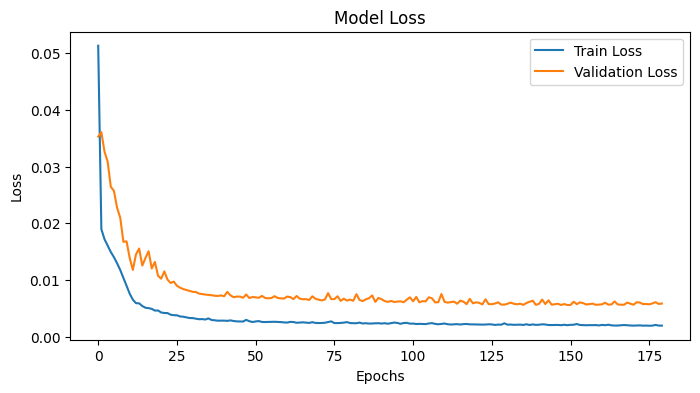

In [ ]:
import matplotlib.pyplot as plt

# 훈련 손실과 검증 손실
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

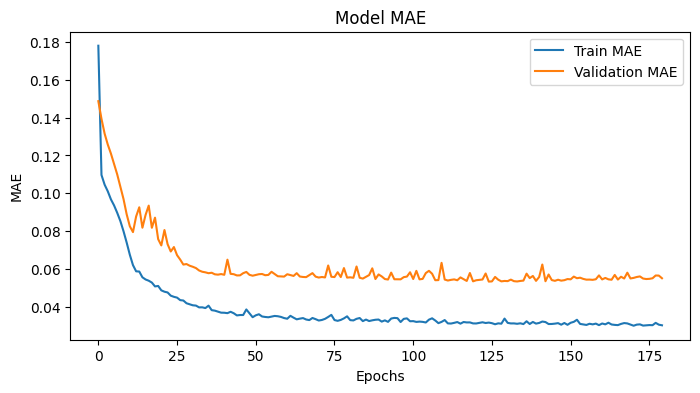

In [ ]:
# 평균 절대 오차(MAE)
plt.figure(figsize=(8, 4))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

# X_test를 사용한 예측 수행
predicted = Model.predict(X_test)

MSE = mean_squared_error(y_test,predicted)
RMSE = np.sqrt(MSE)
print('RMSE :', RMSE)

from sklearn.metrics import r2_score
R2= r2_score(y_test, predicted)
print('R2_score :',R2)

5/5 [==============================] - 1s 7ms/step
RMSE : 0.0814227911498032
R2_score : 0.9092796559388454


In [ ]:
N = 1  # 가정: 마지막 5개 데이터 포인트를 사용
last_points = X_train[-N:]

# LSTM 모델에 맞게 형태 조정
# 예: 하나의 특성만 있는 경우
last_points_array = last_points.reshape(1, 5, 1)

next_value = Model.predict(last_points_array)

# 예측 결과 출력
print("Next predicted value:", next_value[0][0])

1/1 [==============================] - 0s 25ms/step
Next predicted value: 0.073887676


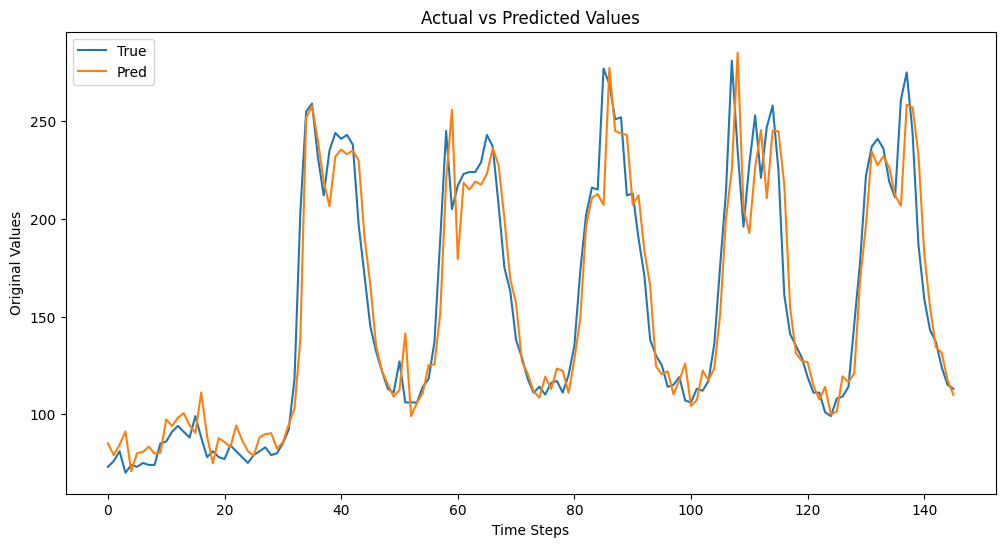

In [ ]:
# 스케일링된 데이터 복구하여 실제값과 비교
scaler = MinMaxScaler()
scaler.fit(X_data[scale_coles])
# 스케일링된 데이터 복구
y_test_original = scaler.inverse_transform(y_test)
predicted_original = scaler.inverse_transform(predicted)

# 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label='True')
plt.plot(predicted_original, label='Pred')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Original Values')
plt.legend()
plt.show()

In [ ]:
# 개인저장소에 있는 파일(inputdata)을 불러오기
from google.colab import files
myfile = files.upload()

Saving 816block5.csv to 816block5.csv


In [ ]:
actual_data = pd.read_csv("816block5.csv")
scale_coles = ['Discharge']

actual_week = actual_data.iloc[1464:1488]
actual_week_discharge = actual_week[scale_coles]

actual_week_discharge
# actual_week_discharge 데이터에 스케일러 적합 및 변환
scaled_actual_week_discharge = scaler.fit_transform(actual_week_discharge)

# 스케일링된 데이터 확인
print(scaled_actual_week_discharge)

[[0.45555556]
 [0.17777778]
 [0.07777778]
 [0.        ]
 [0.01111111]
 [0.13333333]
 [0.31111111]
 [0.5       ]
 [0.73333333]
 [0.85555556]
 [0.9       ]
 [0.96666667]
 [0.94444444]
 [0.84444444]
 [0.78888889]
 [0.77777778]
 [0.83333333]
 [0.97777778]
 [1.        ]
 [0.96666667]
 [0.91111111]
 [0.84444444]
 [0.71111111]
 [0.52222222]]


In [ ]:
def make_sequence_dataset(X, Y, window_size):
    feature_list = []
    label_list = []
    for i in range(len(X) - window_size):
        x = X[i:(i + window_size)]
        y = Y[i + window_size]
        feature_list.append(x)
        label_list.append(y)
    return np.array(feature_list), np.array(label_list)

# 함수 호출
feature, label = make_sequence_dataset(scaled_actual_week_discharge, scaled_actual_week_discharge, window_size)

# 스케일러 복구해서 시퀀스 데이터 확인
feature_original = np.array([scaler.inverse_transform(f.reshape(1, -1)) for f in feature])
label_original = scaler.inverse_transform(label.reshape(-1, 1))

# 형태 출력
print("Feature shape:", feature_original.shape)
print("Label shape:", label_original.shape)

# 데이터 출력
print("Feature data:", feature_original)
print("Label data:", label_original)

Feature shape: (19, 1, 5)
Label shape: (19, 1)
Feature data: [[[ 99.  74.  65.  58.  59.]]

 [[ 74.  65.  58.  59.  70.]]

 [[ 65.  58.  59.  70.  86.]]

 [[ 58.  59.  70.  86. 103.]]

 [[ 59.  70.  86. 103. 124.]]

 [[ 70.  86. 103. 124. 135.]]

 [[ 86. 103. 124. 135. 139.]]

 [[103. 124. 135. 139. 145.]]

 [[124. 135. 139. 145. 143.]]

 [[135. 139. 145. 143. 134.]]

 [[139. 145. 143. 134. 129.]]

 [[145. 143. 134. 129. 128.]]

 [[143. 134. 129. 128. 133.]]

 [[134. 129. 128. 133. 146.]]

 [[129. 128. 133. 146. 148.]]

 [[128. 133. 146. 148. 145.]]

 [[133. 146. 148. 145. 140.]]

 [[146. 148. 145. 140. 134.]]

 [[148. 145. 140. 134. 122.]]]
Label data: [[ 70.]
 [ 86.]
 [103.]
 [124.]
 [135.]
 [139.]
 [145.]
 [143.]
 [134.]
 [129.]
 [128.]
 [133.]
 [146.]
 [148.]
 [145.]
 [140.]
 [134.]
 [122.]
 [105.]]


In [ ]:
# 예측할 시점의 개수 설정
num_steps = 24  # 예를 들어, 다음 24시간을 예측하고자 할 때

# 최근 시퀀스 데이터 선택
last_sequence = feature.reshape(1, -1, 1)  # 마지막 시퀀스의 형태에 맞게 조정
last_sequence
# 다단계 예측을 위한 빈 리스트
multi_step_predictions = []

# 지정된 시점만큼 예측을 반복
for _ in range(num_steps):
    # 현재 시퀀스를 기반으로 다음 시점 예측
    next_step_prediction = Model.predict(last_sequence)
    multi_step_predictions.append(next_step_prediction[0, 0])

    # 다음 예측을 위해 시퀀스 업데이트
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_step_prediction[0, 0]

# 다단계 예측 결과 출력
print("Multi-step predictions:", multi_step_predictions)

1/1 [==============================] - 0s 54ms/step
Multi-step predictions: [0.7359941, 0.72719264, 0.7168322, 0.70811963, 0.70316184, 0.70129853, 0.7019857, 0.7044045, 0.7076942, 0.71109504, 0.7140566, 0.7162703, 0.71763974, 0.71822274, 0.718164, 0.71764565, 0.71684647, 0.7159229, 0.7149977, 0.7141583, 0.7134576, 0.7129199, 0.71254677, 0.71232367]


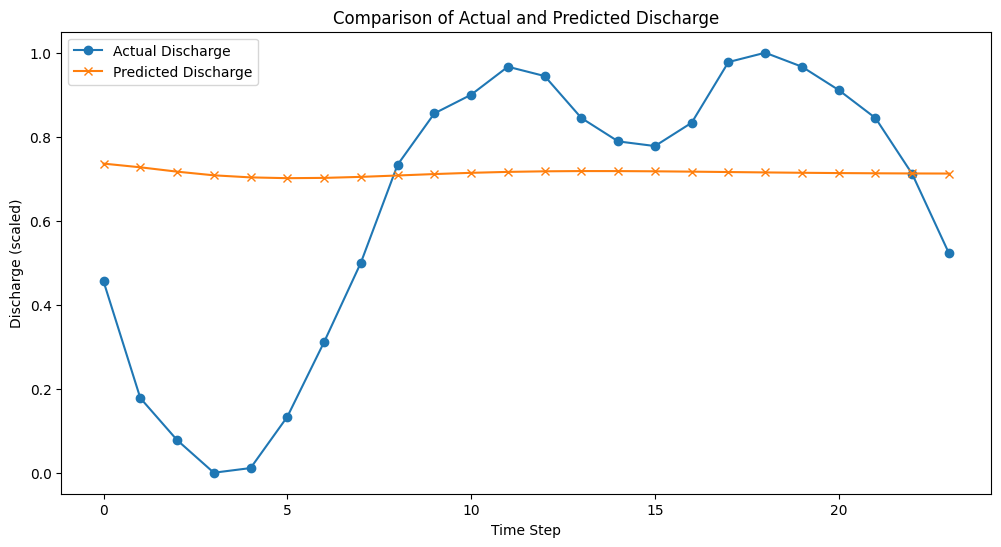

In [ ]:
import matplotlib.pyplot as plt

# scaled_actual_week_discharge를 1차원 배열로 변환 (필요한 경우)
scaled_actual_week_discharge = scaled_actual_week_discharge.flatten()

# multi_step_predictions를 NumPy 배열로 변환
multi_step_predictions_array = np.array(multi_step_predictions)

# 시간 축 생성
time_steps = np.arange(len(scaled_actual_week_discharge))

# 비교 그래프 작성
plt.figure(figsize=(12, 6))
plt.plot(time_steps, scaled_actual_week_discharge, label='Actual Discharge', marker='o')
plt.plot(time_steps, multi_step_predictions_array, label='Predicted Discharge', marker='x')
plt.title('Comparison of Actual and Predicted Discharge')
plt.xlabel('Time Step')
plt.ylabel('Discharge (scaled)')
plt.legend()
plt.show()

In [ ]:
# 결과 데이터를 DataFrame으로 변환
result_df = pd.DataFrame({
    'True Values': y_test_original.flatten(),
    'Predicted Values': predicted_original.flatten()
})

# 결과 데이터를 엑셀 파일로 저장 (Colab 환경에 임시 저장)
file_path = '/content/predicted_results.xlsx'
result_df.to_excel(file_path, index=False)

from google.colab import files
files.download('/content/predicted_results.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>